In [1]:
%matplotlib inline
import time

# python 3
import urllib.error
from urllib.request import urlopen
import datetime
#from itertools import ifilter
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET

from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import bibtexparser

pd.set_option('mode.chained_assignment','warn')

In [2]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def harvest(arxiv="physics:astro-ph", from_date="2016-08-01", until_date="2016-08-31"):
    """
    input: arxiv is the "set" defined in http://export.arxiv.org/oai2?verb=ListSets
    """
    df = pd.DataFrame(columns=("title", "abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords"
    url = (base_url +
           "&from=%s" % from_date +
           "&until=%s" % until_date + 
           "&metadataPrefix=arXiv&set=%s"%arxiv)
    
    while True:
        print("fetching", url)
        try:
            response = urlopen(url)
            
        except urllib.error.HTTPError as e:
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print("Got 503. Retrying after {0:d} seconds.".format(to))

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            info = meta.find(ARXIV+"arXiv")
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]
                
            contents = {'title': info.find(ARXIV+"title").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }

            df = df.append(contents, ignore_index=True)

        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break

        else:
            url = base_url + "&resumptionToken=%s"%(token.text)
            
    return df
    

In [3]:
# df = harvest(arxiv="physics:astro-ph")

In [162]:
store = pd.HDFStore("astroph_Aug2016.h5")

In [163]:
#store['df'] = df
df = store['df']

In [164]:
store.close()

In [165]:
ts = df['created'][0].to_pydatetime()

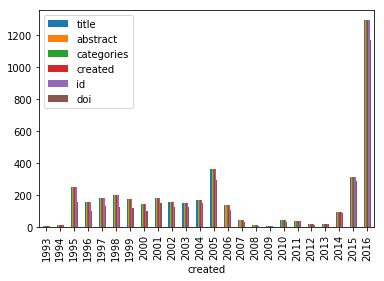

In [166]:
df.groupby(df["created"].dt.year).count().plot(kind="bar")

In [167]:
# assign label and remove those with sub-categories..
target_name_dict = { 'astro-ph.GA' : 0,
                     'astro-ph.SR' : 1,
                     'astro-ph.IM' : 2,
                     'astro-ph.EP' : 3,
                     'astro-ph.HE' : 4,
                     'astro-ph.CO' : 5
                   }

for i, rows in df.iterrows():
    cat = df.get_value(i, 'categories')
    if any(['astro-ph.' in c for c in cat]):
        for j in range(len(cat)):
            if cat[j] in target_name_dict.keys():
                label = target_name_dict[cat[j]]
#                print(i, label, cat)
                df.set_value(i, 'label', label)
                break
    else:
        df.drop(i, inplace=True)
        
# https://stackoverflow.com/questions/28885073/reindexing-after-pandas-drop-duplicates
df.reset_index(drop=True, inplace=True) # reset the index after dropping

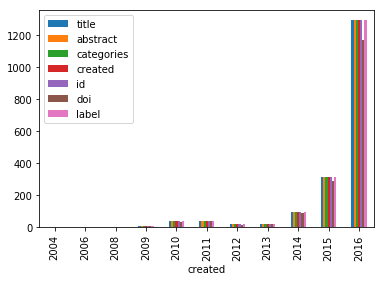

In [168]:
df.groupby(df["created"].dt.year).count().plot(kind="bar")

In [169]:
abstract = df['abstract'][100]

In [170]:
# remove string between $ $ 
# https://stackoverflow.com/questions/6857296/remove-contents-between-brackets-from-string
import re
abstract = re.sub(r'\$.*?\$', ' ', abstract)
abstract = re.sub(r'\n', ' ', abstract)

# remove punctuation in the abstract
# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
import string
#translator1 = str.maketrans("", "", string.punctuation)
translator1 = str.maketrans(string.punctuation, " "*32)
translator2 = str.maketrans("", "", string.digits)
abstract = abstract.translate(translator1)
abstract = abstract.translate(translator2)

In [171]:
abstract

'Despite astrophysical importance of binary star systems  detections are limited to those located in small ranges of separations  distances  and masses and thus it is necessary to use a variety of observational techniques for a complete view of stellar multiplicity across a broad range of physical parameters  In this paper  we report the detections and measurements of  binaries discovered from observations of microlensing events MOA  BLG  and OGLE  BLG   Determinations of the binary masses are possible by simultaneously measuring the Einstein radius and the lens parallax  The measured masses of the binary components are     and     for MOA  BLG  and     and     for OGLE  BLG  and thus both lens components of MOA  BLG  and one component of OGLE  BLG  are M dwarfs  demonstrating the usefulness of microlensing in detecting binaries composed of low mass components  From modeling of the light curves considering full Keplerian motion of the lens  we also measure the orbital parameters of the

In [172]:
Nabstract = len(df['abstract'])
print(Nabstract)

1843


In [173]:
import string
#translator1 = str.maketrans("", "", string.punctuation)
translator1 = str.maketrans(string.punctuation, " "*32)
translator2 = str.maketrans("", "", string.digits)

for i, rows in df.iterrows():
    abstract = df.abstract[i].lower()
    abstract = re.sub(r'\$.*?\$', ' ', abstract) # remove latex
    abstract = re.sub(r'\n', ' ', abstract) # remove end of line
    abstract = re.sub(r'x\-ray', 'xray', abstract) # replace x-ray by xray
    

    # remove punctuation in the abstract
    # https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
    abstract = abstract.translate(translator1)
    abstract = abstract.translate(translator2)
    
    # assign value back to dataFrame
    # https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row
    df.set_value(i, 'abstract', abstract)
    

In [174]:
df.abstract[i]

'clover is an experiment which aims to detect the signature of gravitational waves from inflation by measuring the b mode polarization of the cosmic microwave background  clover consists of three telescopes operating at     and  ghz  the  ghz telescope has  horns in its focal plane while the  and  ghz telescopes have  horns each  the horns are arranged in a hexagonal array and feed a polarimeter which uses finline coupled tes bolometers as detectors  to detect the two polarizations the  ghz telescope has  detectors while the  and  ghz telescopes have  detectors each  to achieve the required neps the detectors are cooled to  mk for the  and  ghz polarimeters and  mk for the  ghz polarimeter  each detector is fabricated as a single chip to guarantee fully functioning focal planes  the detectors are contained in linear modules made of copper which form split block waveguides  the detector modules contain  or  detectors each for compatibility with the hexagonal arrays of horns in the teles

In [137]:
#word_bag = " ".join(df.abstract.apply(lambda t: t.lower()))
word_bag = " ".join(df.abstract)

Counter(word_bag.split()).most_common(n=10)

[('the', 28749),
 ('of', 16043),
 ('and', 9653),
 ('a', 8029),
 ('in', 7425),
 ('to', 6978),
 ('we', 5427),
 ('with', 4237),
 ('is', 4025),
 ('that', 3768)]

In [138]:
from nltk.corpus import stopwords

stops = [word for word in stopwords.words('english')]
stops += ["=", "->"]
#words = filter(lambda w: w not in stops,
#               word_bag.split())
words = [word for word in word_bag.split() if word not in stops]
top_twenty = Counter(words).most_common(n=20)

In [139]:
top_twenty

[('mass', 1392),
 ('star', 1054),
 ('data', 1015),
 ('stars', 990),
 ('galaxies', 928),
 ('model', 920),
 ('observations', 873),
 ('high', 865),
 ('emission', 841),
 ('using', 821),
 ('find', 791),
 ('stellar', 781),
 ('also', 768),
 ('field', 733),
 ('observed', 710),
 ('two', 709),
 ('present', 695),
 ('energy', 681),
 ('galaxy', 678),
 ('large', 672)]

In [140]:
import nltk.stem as stem

porter = stem.PorterStemmer()
#for w in ("measurement", "measurements", "measured", "measure"):
#    print(w, "->", porter.stem(w))
for w in ("galaxy", "galaxies", "galactic"):
    print(w, "->", porter.stem(w))

galaxy -> galaxi
galaxies -> galaxi
galactic -> galact


In [141]:
#word_stems = map(lambda w: (porter.stem(w),w), words)
word_stems_list = [(porter.stem(w),w) for w in words ]
stem2words = defaultdict(set)
for stem1, word in word_stems_list:
    stem2words[stem1].add(word)

In [142]:
def bar_chart(items):
    """Make a bar chart showing the count associated with each key
    
    `items` is a list of (key, count) pairs.
    """
    width = 0.5
    ind = np.arange(len(items))
    lab = np.array([ k for k, v in items])
    val = np.array([ v for k, v in items])
    fig, ax = plt.subplots(figsize=(15,8))
    rects1 = ax.bar(ind, val, width, color='r')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(lab)
    fig.autofmt_xdate()
    plt.show()

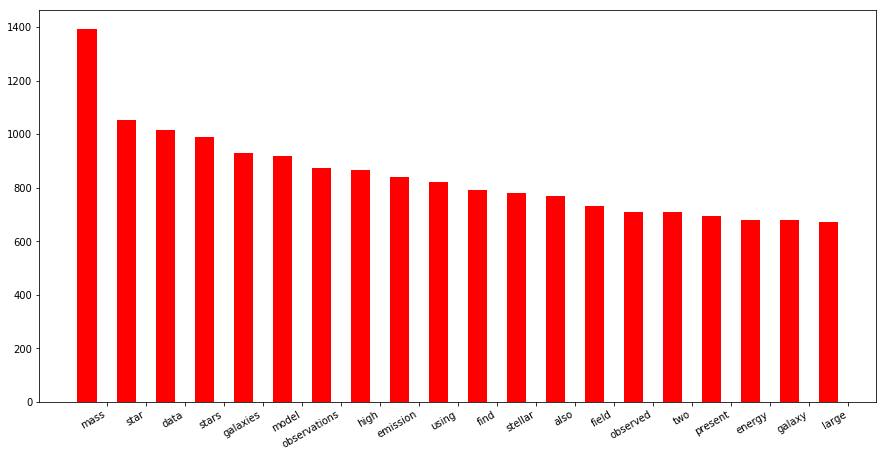

In [143]:
bar_chart(top_twenty)

In [110]:
new_top_twenty = Counter([s[0] for s in word_stems_list]).most_common(n=20)

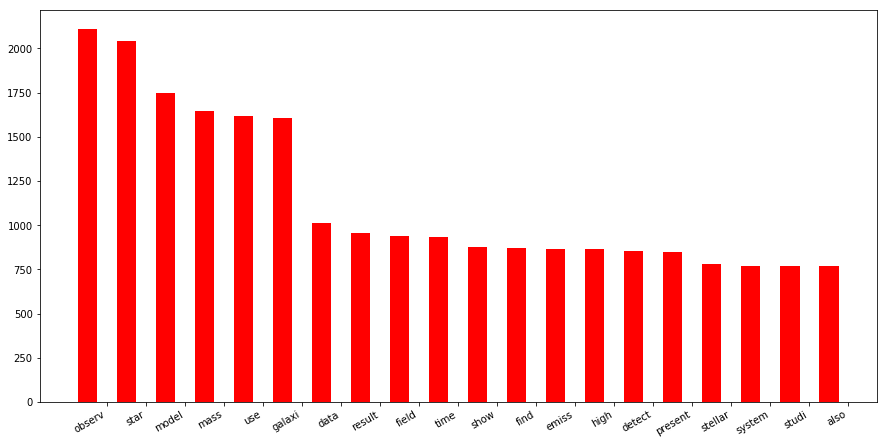

In [111]:
bar_chart(new_top_twenty)

In [112]:
stem2words['gravit']

{'gravitating', 'gravitation', 'gravitational', 'gravitationally'}

In [113]:
stem2words['rv']

{'rv', 'rvs'}

In [114]:
[s[0] for s in word_stems_list]

['gener',
 'sketch',
 'problem',
 'space',
 'dimension',
 'depend',
 'anthrop',
 'argument',
 'present',
 'new',
 'argument',
 'favor',
 'stabl',
 'scenario',
 'space',
 'dimension',
 'time',
 'scale',
 'longer',
 'requir',
 'exist',
 'human',
 'anoth',
 'kind',
 'highli',
 'evolv',
 'life',
 'earth',
 'propos',
 'seismolog',
 'studi',
 'pulsat',
 'pg',
 'star',
 'pg',
 'pg',
 'present',
 'perform',
 'extens',
 'adiabat',
 'comput',
 'g',
 'mode',
 'pulsat',
 'period',
 'pg',
 'evolutionari',
 'model',
 'stellar',
 'mass',
 'rang',
 'msun',
 'constrain',
 'stellar',
 'mass',
 'pg',
 'pg',
 'compar',
 'observ',
 'period',
 'space',
 'star',
 'theoret',
 'asymptot',
 'period',
 'space',
 'averag',
 'comput',
 'period',
 'space',
 'also',
 'employ',
 'individu',
 'observ',
 'period',
 'find',
 'repres',
 'seismolog',
 'model',
 'star',
 'low',
 'mass',
 'star',
 'format',
 'describ',
 'gravit',
 'collaps',
 'dens',
 'core',
 'ga',
 'dust',
 'point',
 'collaps',
 'disk',
 'form',
 'around'

In [115]:
len(stem2words)

8312

In [116]:
nltk.download()

NameError: name 'nltk' is not defined

In [117]:
len(string.punctuation)

32

In [118]:
spaces32 = " " * 32

In [119]:
spaces32

'                                '

In [120]:
df.keys()

Index(['title', 'abstract', 'categories', 'created', 'id', 'doi', 'label'], dtype='object')

In [121]:
df.title[100]

'A multiwavelength approach to BD+53$^\\circ$2790: the O9.5V counterpart\n  to the X-ray binary system 4U~2206+54'

In [122]:
title = 'x-ray binary'
title = re.sub(r"xX\-ray", 'xray', title)

In [123]:
title

'x-ray binary'

In [124]:
df

,title,abstract,categories,created,id,doi,label
23,A note on space dimensionality constraints rel...,a general sketch of how the problem of space d...,"[physics.hist-ph, astro-ph, astro-ph.GA]",2008-06-03,0806.0684,None,1.0
31,Seismological constraints on the high-gravity ...,a seismological study of the pulsating pg star...,[astro-ph.SR],2009-03-23,0903.3912,10.1088/1742-6596/172/1/012078,5.0
32,The kinematics of NGC1333-IRAS2A - a true Clas...,low mass star formation is described by gravit...,"[astro-ph.GA, astro-ph.SR]",2009-05-28,0905.4575,10.1051/0004-6361/200810831,1.0
33,Optically-passive spirals: The missing link in...,galaxies migrate from the blue cloud to the re...,"[astro-ph.CO, astro-ph.GA]",2009-06-01,0906.0306,None,7.0
34,Studies of Cosmic Ray Composition and Air Show...,studies of the composition of the highest ener...,"[astro-ph.CO, astro-ph.HE]",2009-06-11,0906.2319,None,7.0
35,The Super-Alfv\'enic Model of Molecular Clouds...,recent measurements of the zeeman effect in da...,[astro-ph.GA],2009-07-03,0907.0587,10.1088/0004-637X/702/1/L37,1.0
36,Rapid Merger of Binary Primordial Black Holes:...,we propose a new scenario for the evolution of...,"[astro-ph.CO, gr-qc]",2009-09-09,0909.1738,10.1093/pasj/psw065,7.0
37,Radial orbit instability: review and perspectives,this paper presents elements about the radial ...,[astro-ph.GA],2009-10-27,0910.5177,10.1080/00411450.2011.654750,1.0
38,Acceleration and radiation of ultra-high energ...,clusters of galaxies are believed to be capabl...,[astro-ph.HE],2009-10-29,0910.5715,10.1051/0004-6361/200913568,6.0
39,Simultaneous multi-frequency observation of th...,the blazar pg is a well known tev gamma ray ...,"[astro-ph.HE, astro-ph.CO]",2009-11-05,0911.1088,10.1051/0004-6361/200913607,6.0


In [125]:
df.index

Int64Index([  23,   31,   32,   33,   34,   35,   36,   37,   38,   39,
            ...
            1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 2615, 3065],
           dtype='int64', length=1843)

In [144]:
for i in df.index[:10]:
    print(i, df.label[i])

0 1.0
1 5.0
2 1.0
3 7.0
4 7.0
5 1.0
6 7.0
7 1.0
8 6.0
9 6.0


In [175]:
store = pd.HDFStore("astroph_Aug2016_preprocessed.h5")
store['df'] = df
store.close()

/home/wklee/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['title', 'abstract', 'categories', 'id', 'doi']]

  exec(code_obj, self.user_global_ns, self.user_ns)
